# Classic Segmentation

<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../notebooks/4_python_basics/Intro_to_Python_II.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/4_python_basics/Intro_to_Python_II.ipynb" target="_blank">
        <img class="button-icon" src="../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "tifffile",
# ]
# ///

## Overview

This notebook covers the following steps in building a **classic segmentation pipeline**:

| Step | Concept | Why it matters |
|---------|---------|----------------|
| 0 | Setup | Import dependencies |
| 1 | Loading an Image | Open tif image and display it |
| 2 | Filtering | Learn how to filter images to improve thresholding results |
| 3 | Thresholding | Learn how to use thresholding to generate a binary mask |
| 4 | Labeling | Learn how to label binary masks |
| 5 | Mask Refinement | Learn how to use apply mathematical operations to refine binary masks |
| 6 | Processing Many Images | Learn how to apply processing steps to many images |


Each chapter has:

1. **Summary** – review core concepts from lecture.
2. ✍️ **Exercise** – _your turn_ to write code!

***

## 0. Setup

**Concept.**  
We are going to be using existing Python libraries in this lesson, so we need to specify them at the beginning of our code. This is called specifying our **dependencies**. It's standard practice to specify all dependencies at the very beginning of your code.

For learning purposes, we will import everything here step by step, as it is introduced in the following sections.

### ✍️ Exercise: Specify dependencies and run the code block for each section

In [46]:
# specify dependencies
import matplotlib.pyplot as plt
import ndv
import numpy as np
import tifffile
from scipy.ndimage import distance_transform_edt
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label
from skimage.morphology import binary_closing, disk, remove_small_objects
from skimage.segmentation import watershed

***

## 1. Loading an Image

**Concept.**
To work with an image in Python, we need to specify where the image file is so that we can **read**, or load, it. Once the image file is read, we can **view** it and process it.  

### Specifying your file's path
Once you have found your file's path, you should assign it to a variable to make it easy to work with. Here's an example:
```python
file_path = '/Users/edelase/Desktop/projects/bobiac/lectures/classic_segmentation/img.tif'
```

<p class="alert alert-warning">
    <strong>Caution:</strong> Be wary of spaces in folder names, as they sometimes cause terminal to add <b>\</b> or <b>/</b> to file directories where they should not be. It is best practice to always use <b>_</b> in folder names whenever you would have wanted to have a space.
</p>

<p class="alert alert-info">
    <strong>Note:</strong> Specifying file paths is a common task outside of image segmentation with Python, so some of you may have experience with this already. Note the terminology though. An individual file's location is a <b> path</b>. A folder's path containing an individual or multiple files is called a <b>directory</b>.
</p>

### ✍️ Exercise: Specify your image file's path and assign it to the variable `image_path`

In [47]:
image_path = "../../../_static/images/classic_seg/DAPI_wf_0.tif"

### Loading an image
There are many different ways to read image files in Python. In this lesson, we will use the Python library `tifffile`, to read .tif image files. We will need to import `tifffile` in Setup. We should also import `numpy` to take advantage of accessing np.array tools you have learned about in the previous lesson.

| Name | Description | How to import it | Documentation Link | 
|---------|---------|----------------| ----------------|
| `tifffile` | Reads and stores tiff files as np.arrays | `import tifffile` | [tifffile](https://pypi.org/project/tifffile//) |
| `numpy` | Scientific computing package that contains np.arrays | `import numpy as np` | [numpy](https://numpy.org) |

In order to read an image with `tifffile`, we will need to import it, and then provide it with the image's path. We will also import `numpy` too, although it is not necessary for `tifffile` to load the image.
```python
import tifffile # put in Setup
import numpy as np # put in Setup
raw_image = tifffile.imread(image_path)
```
`tifffile.imread()` will use that `image_path` you inputted to find your file and read it. It will then return the read file. Since we will be wanting to work with this file, we assign it to the variable `raw_image` for easy reference. 

### ✍️ Exercise: Use `tifffile` to read the image and assign it to the variable `raw_image`. Then, print its shape and dtype 
Remember to add your imports to Setup!

In [48]:
raw_image = tifffile.imread(image_path)
print(raw_image.shape, raw_image.dtype)

(2304, 2304) float32


<p class="alert alert-info">
    <strong>Note:</strong> When we print this image's dtype, we see that it is <b>uint32</b>, or 32 bit. This is because the images we will be working with in this lesson did not come straight from the microscope. Before providing them to you, we applied a <b>background subtraction</b>. You will learn about background subtraction in a future lesson. 
</p>

### Viewing the image
In Python, reading the image and viewing it are two separate actions. Now that we have read the image and assigned it to the variable `raw_image`, we can view it using `ndv`, which we will need to import in Setup. 

| Name | Description | How to import it | Documentation Link | 
|---------|---------|----------------| ----------------|
| `ndv` | Multi-dimensional image viewer | `import ndv` | [ndv](https://pypi.org/project/ndv/) |

We can use ndv to view `raw_image` as follows: 
```python
import ndv # put in Setup
ndv.imshow(raw_image)
```
`ndv.imshow()` will use that `raw_image` you inputted to display your image. It will then return the image displayed in the ndv viewer. 

### ✍️ Exercise: Use `ndv` to view the image `raw_image`
Remember, we need to import ndv in Setup!

In [ ]:
ndv.imshow(raw_image)

In [ ]:
viewer = ndv.imshow(raw_image)

In [ ]:
viewer.widget().children[1].snapshot()

***

## 2. Filtering

**Concept.**  
**Filters** change image pixel values using a **mathematical operation**. Here, we use them to smooth and reduce **noise** from images. Doing so can help improve thresholding results. 

### Applying a filter to an image
Here's a summary of the filters we covered in lecture that are good at reducing noise from images: 

| Filter Name | Description | How to import it | Documentation Link | 
|---------|---------|----------------| ----------------|
| mean filter | For a given kernel size, sums values in a list and and then divides by the total number of values | `from skimage.filters.rank import mean` | [skimage.filters.rank.mean](https://scikit-image.org/docs/0.25.x/api/skimage.filters.rank.html#skimage.filters.rank.mean) |
| Gaussian blur filter | For a given kernel size, multiply each value by a Gaussian profile weighting, then divide by the total number of values | `from skimage.filters import gaussian` | [skimage.filters.gaussian](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian) |
| median filter | For a given kernel size, take the middle number in a sorted list of numbers | `from skimage.filters import median` | [skimage.filters.median](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.median) |

Don't forget to review the documentation to see how to specify the kernel size for each filter!

### ✍️ Exercise: Write code to apply a Gaussian blur filter to `raw_image` and assign it to the variable `filtered_image`
Remember - we need to import the `gaussian` function from `skimage.filters` in Setup!

In [49]:
filtered_image = gaussian(raw_image, sigma=1)

### ✍️ Exercise: View `filtered_image` with `ndv`

In [ ]:
ndv.imshow(filtered_image)

In [ ]:
viewer = ndv.imshow(filtered_image)

In [ ]:
viewer.widget().children[1].snapshot()

***

## 3. Thresholding

**Concept.**  
**Thresholding** is when we select a range of digital values, or **intensity values**, in the image. These selected values are how we define regions of the image we are interested in. 

### Defining a threshold
We need to define a minimum intensity cutoff which separates the **background** (what we don't care about) from the **foreground** (what we do care about). We can manually pick an intensity value as this cutoff value like below:
```python
threshold = 50
```

However, manually changing the value assigned to `threshold` until we find an optimal intensity cutoff value is tedious and may vary between images in a dataset. Therefore, it is best practice to instead use established **thresholding algorithms** to automatically define an intensity cutoff value. `skimage.filters` contains many different types of thresholding algorithms, but from that we will be using the Otsu thresholding algorithm `threshold_otsu`. 

| Thresholding Algorithm | Description | How to import it | Documentation Link | 
|---------|---------|----------------| ----------------|
| Otsu thresholding | Returns threshold using Otsu's method | `from skimage.filters import threshold_otsu` | [threshold_otsu](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu) |

<p class="alert alert-info">
    <strong>Note:</strong> <b>skimage.filters</b> also has a <b>try_all_threshold()</b> function that takes an inputted image and returns a figure comparing the outputs of different thresholding methods. It can be a helpful tool to pick a good thresholding algorithm!
</p>

We can use `threshold_otsu` from `skimage.filters` as follows: 
```python
from skimage.filters import threshold_otsu # put in Setup
threshold = threshold_otsu(filtered_image)
```
Here, `threshold_otsu()` will use that inputted `filtered_image` to calculate an intensity cutoff value. It will return the cutoff value assigned to the variable `threshold`. 

### ✍️ Exercise: Write code to calculate a threshold on `filtered_image` using Otsu's method
Remember - we need to import the `threshold_otsu` function from `skimage.filters` in Setup!

In [50]:
threshold = threshold_otsu(filtered_image)

### Generating a binary mask
We now want to use this cutoff value to generate a **binary mask**, which is an image that has only 2 pixel values: one corresponding to the background and one corresponding to the foreground. By generating the binary mask, we will be able to evaluate whether this `threshold` is a sufficient cutoff value. 

We can generate the binary mask by using *any* comparison operator. Since we want to accept values above a given threshold as foreground, let's use the comparison operator `>`:
```python
binary_mask = filtered_image > min_threshold
```
Python will interpret this line of code by going pixel by pixel through `filtered_image` and assigning `True` values where a pixel is greater than `threshold` and assigning `False` values where a pixel is equal or less than `threshold`. The output will be the binary mask image, filled with `True` and `False`. Since this binary mask is something we will be working with, we should assign it a variable, such as `binary_mask`. 

### ✍️ Exercise: Write code to threshold `filtered_image` and generate a binary image assigned to the variable `binary_mask`. Print this image's minimum and maximum values.

In [51]:
binary_mask = filtered_image > threshold
print(np.max(binary_mask))  # binary_mask max value
print(np.min(binary_mask))  # binary_mask min value

True
False


### Comparing the binary mask to the raw image
We can use `matplotlib.pyplot` to view the `raw_image` and `binary_mask` side by side. We first need to import `matplotlib.pyplot` in Setup, which can be abbreviated as `plt` for simplicity. 

| Name | Description | How to import it | Documentation Link | 
|---------|---------|----------------| ----------------|
| `matplotlib.pyplot` | Creates interactive plots | `import matplotlib.pyplot as plt` | [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) |

Just as you learned in the last lesson, we can use `plt` to plot images. Plotting 2 images for side by side comparison is a very useful task, so let's package this code into a function, like the one written below:

```python
import matplotlib.pyplot as plt # put in Setup

def double_image_plotter(img_1:np.array, img_2:np.array) -> None:
    """ Function that plots 2 images side by side with their variable names as titles

    Parameters
    ----------
    img_1: np.array
    left plotted image

    img_2: np.array
    right plotted image
    
    Return
    ----------
    None: plot of the images

    """
    # Create a figure and axis
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

    # Plot images
    axes[0].imshow(img_1, cmap='gray', vmin=img_1.min(), vmax=img_1.max())
    axes[0].axis('off')  # Turn off axis
    axes[1].imshow(img_2, cmap='gray', vmin=img_2.min(), vmax=img_2.max())
    axes[1].axis('off')  # Turn off axis

    # Show the plot
    plt.show()
```

We can then call this `double_image_plotter` function whenever we want to plot 2 images side by side!

### ✍️ Exercise: Write a function named `double_image_plotter` that uses `plt` to plot two images side by side
Remember to import `matplotlib.pyplot` as `plt` in Setup!

In [52]:
def double_image_plotter(img_1: np.array, img_2: np.array) -> None:
    """Function that plots 2 images side by side with their variable names as titles

    Parameters
    ----------
    img_1: np.array
    left plotted image

    img_2: np.array
    right plotted image

    Return
    ----------
    None: plot of the images

    """
    # Create a figure and axis
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

    # Plot images
    axes[0].imshow(img_1, cmap="gray", vmin=img_1.min(), vmax=img_1.max())
    axes[0].axis("off")  # Turn off axis
    axes[1].imshow(img_2, cmap="gray", vmin=img_2.min(), vmax=img_2.max())
    axes[1].axis("off")  # Turn off axis

    # Show the plot
    plt.show()

### ✍️ Exercise: View `raw_image` and `binary_mask` side by side using the `double_image_plotter` function you just made

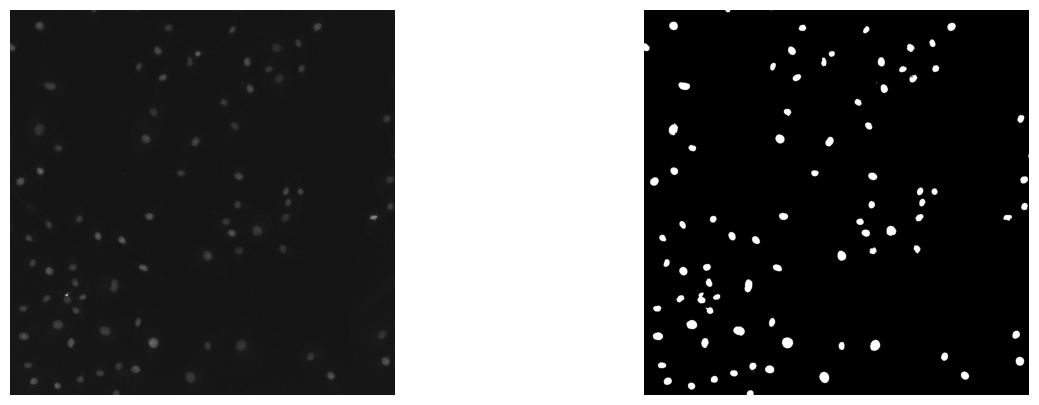

In [53]:
double_image_plotter(raw_image, binary_mask)

***

## 4. Mask Labeling

**Concept.**  
Now that we have a binary mask that has white, or value `True`, pixels that match the image foreground and black, or value  `False`, pixels that match the image background, we can continue further to distinguish individual objects within this mask. **Labeling** a mask is when we identify individual objects within a binary mask and assign them a unique numerical identifier. 

### Labeling a binary mask
From `skimage.measure` we can use `label()` to label a curated binary mask.

| Function | Description | How to import it | Documentation Link | 
|---------|---------|----------------| ----------------|
| `label()` | Label connected regions of an image for Instance segmentation | `from skimage.measure import label` | [skimage.measure.label](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) |

Here's how we use `label` from `skimage.measure` to label a binary mask: 
```python
from skimage.measure import label # put in Setup
labeled_image = label(binary_mask)
```
Here, `label()` will take the inputted `binary_mask` and count each connected object in the image. It will then assign each object a whole number starting from 1. It will then return an image where each object's pixels have the value of its object's assigned number, which we assign to the variable `labeled_image`!

### ✍️ Exercise: Write code to label `binary_mask` and assign it to the variable `labeled_image`
Remember - we need to import the `label function` from `skimage.measure` in Setup!

In [37]:
labeled_image = label(binary_mask)

### Displaying a labeled mask on top of the image
Let's now summarize our final segmentation result in 1 image by viewing the `labeled_image` overlaid onto the original `raw_image`. From `skimage.color`, we can use `label2rgb` to do this. 

| Function | Description | How to import it | Documentation Link | 
|---------|---------|----------------| ----------------|
| `label2rgb()` | Returns an RGB image where color-coded labels are painted over the image | `from skimage.color import label2rgb` | [label2rgb](https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.label2rgb) |

Here's how we can use `label2rgb` from `skimage.color` to summarize our segmentation result: 
```python
from skimage.color import label2rgb # put in Setup
seg_summary = label2rgb(labeled_image, image = raw_image)
```
Here, `label2rgb()` is filled with 2 arguments: 
1. The labeled mask `labeled_image`
2. The original image we want the `labeled_image` overlaid onto, specified as `image = raw_image`

The output will be an rgb image of the labeled mask overlaid onto the raw image, which is assigned to the variable `seg_summary`.

### ✍️ Exercise: Write code that creates an image of `labeled_image` overlaid onto `raw_image` and assign it to the variable `seg_summary`
Remember - we need to import the `label2rgb` function from `skimage.color` in Setup!

In [ ]:
seg_summary = label2rgb(labeled_image, image=raw_image)

### ✍️ Exercise: View `seg_summary` with `plt`

In [ ]:
plt.imshow(seg_summary)

How does the segmentation result look? Are all labels corresponding to individual nuclei? If not, additional processing steps are needed to refine `binary_mask`.

***

## 5. Mask Refinement

**Concept.**  
**Mask refinement** is needed when a binary mask still does not accurately match the image foreground after filtering and thresholding. In the context of our nuclei example image, we need to apply additional processing steps to remove objects that are too small to be nuclei, fill any holes within nuclei, and separate touching nuclei.

### Common mask refinement steps
There are many different ways we can refine a binary mask. The table below summarizes the refinement steps we discussed in lecture:

| Function Name | Description | How to import it | Documentation Link |
|---------|---------|----------------|----------------|
| `remove_small_objects()` | Removes objects smaller than the specified size from the foreground.  | `from skimage.morphology import remove_small_objects` | [skimage.morphology.remove_small_objects](https://scikit-image.org/docs/0.25.x/api/skimage.morphology.html#skimage.morphology.remove_small_objects) |
| `binary_closing()` | Performs morphological closing, a mathematical operation that results in small hole removal | `from skimage.morphology import binary_closing` | [skimage.morphology.binary_closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.binary_closing) |
| `watershed()` | Performs the Watershed transform, a useful algorithm for separating touching objects. The output is a labeled image. | `from skimage.segmentation import watershed` | [skimage.segmentation.watershed](https://scikit-image.org/docs/0.25.x/api/skimage.segmentation.html#skimage.segmentation.watershed) |

Let's now walk through steps to remove objects smaller than nuclei with `remove_small_objects()`, fill in any holes within nuclei with `binary_closing()`, and then separate touching nuclei with `watershed()`.

### Removing objects smaller than nuclei
In many cases, thresholding will be unsuccessful at rejecting image objects that are debris, as these tend to have high intensity values. However, we can use differences in object size to reject anything that is too small to be a nucleus. 

From `skimage.morphology` we can use the `remove_small_objects` function to remove any connected objects of a specified `min_size`. Here is how we can do that:
```python
from skimage.morphology import remove_small_objects # put in Setup
binary_mask_sized = remove_small_objects(binary_mask, min_size=10)
```
Here, `remove_small_objects()` will take the inputted `binary_mask` and set any connected object that is smaller than `min_size=10` to have `False` values (in other words, be rejected as foreground). It will then return the updated binary mask, which we assigned to the variable `binary_mask_sized`.

### ✍️ Exercise: Write code to remove objects smaller than nuclei in `binary_mask` and assign it to the variable `binary_mask_sized`
Remember, we need to import functions we want to use in Setup!

In [54]:
binary_mask_sized = remove_small_objects(binary_mask, min_size=10)

### ✍️ Exercise: Use our `double_image_plotter` function to display `binary_mask` and `binary_masked_sized` side by side

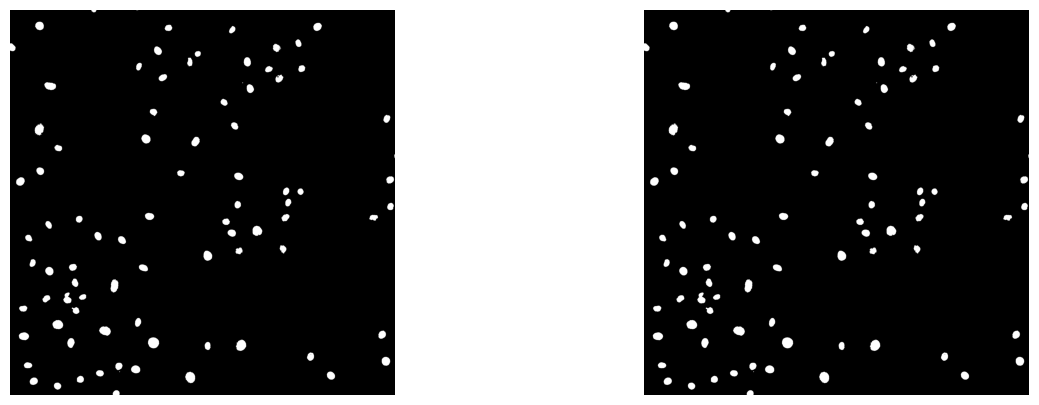

In [55]:
double_image_plotter(binary_mask, binary_mask_sized)

### Filling holes within nuclei
While filtering helps reduce the effect of noise on thresholding, sometimes there will still be areas **within** an object that are below the minimum threshold value. These areas will show up as holes within a connected object. We can fill these holes by applying a morphological closing operation to the mask. 

From `skimage.morphology` we can use the `binary_closing` function to fill small holes within nuclei. Here is how we can do that:
```python
from skimage.morphology import binary_closing # put in Setup
from skimage.morphology import disk # put in Setup
binary_mask_filled = binary_closing(binary_mask_sized, disk(1))
```
Here, `binary_closing()` has two inputs: 
1. The binary mask `binary_mask_sized` 
2. A footprint `disk(1)`, which is a disk shaped kernel of size 1 

It uses these inputs to perform a morphological closing operation optimized for binary images. It will then return the updated binary mask, which we assign to the variable `binary_mask_filled`.

### ✍️ Exercise: Write code to fill holes within nuclei in `binary_mask_sized`, and assign the updated mask to the variable `binary_masked_filled`
Remember, we need to import functions we want to use in Setup!

In [56]:
binary_mask_filled = binary_closing(binary_mask_sized, disk(5))

### ✍️ Exercise: Use our `double_image_plotter` function to display `binary_mask_sized` and `binary_mask_filled`

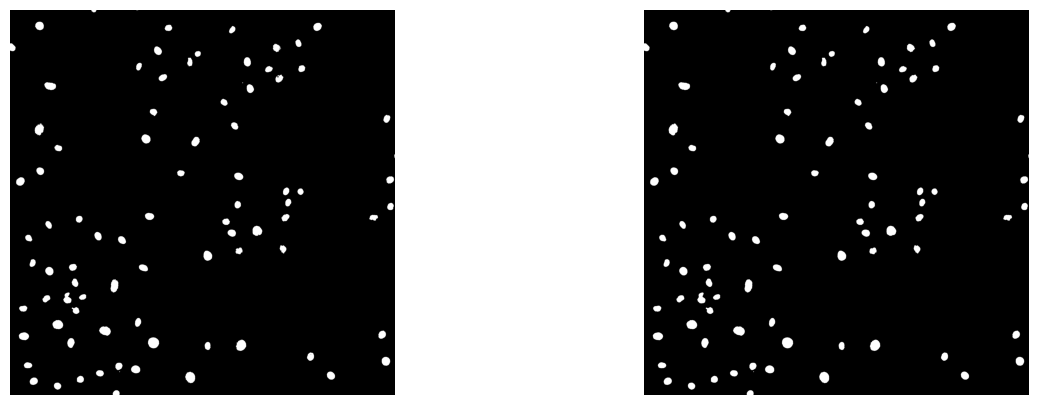

In [57]:
double_image_plotter(binary_mask_sized, binary_mask_filled)

### Separating touching nuclei
Let's now apply the Watershed transform to our `binary_mask` to separate any touching nuclei. From `skimage.segmentation`, we can use `watershed()` to do this. 

The `watershed()` function needs the following inputs:
1. The inverse of the distance transform of the binary mask
2. The seeds: labeled image of the peaks of the distance transform
3. The binary mask

We are going to need a few additional functions to provide the first two inputs to the `watershed()` function. 

| Function | Description | How to import it | Documentation Link |
|---------|---------|----------------|----------------|
| `distance_transform_edt()` | Calculates the distance transform of the input | `from scipy.ndimage import distance_transform_edt` | [scipy.ndimage.distance_transform_edt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html) |
| `peak_local_max` | Remove objects smaller than the specified size from the foreground.  | `from skimage.feature import peak_local_max` | [skimage.feature.peak_local_max](https://scikit-image.org/docs/0.25.x/api/skimage.feature.html#skimage.feature.peak_local_max) |

#### Computing the distance transform
We can use the `distance_transform_edt()` function from `scipy.ndimage` to get the distance transform of our refined binary_mask `binary_mask_filled`:
```python
from scipy.ndimage import distance_transform_edt # put in Setup
# compute the distance transform
distance_transform = distance_transform_edt(binary_mask_filled)
```

### ✍️ Exercise: Write code to calculate the distance transform of `binary_mask_filled` and assign it to the variable `distance_transform`
Remember to import what you need in Setup!

In [44]:
# compute the distance transform
distance_transform = distance_transform_edt(binary_mask_filled)

#### Creating seeds for Watershed
Once we have the distance transform of `binary_mask_filled`, we can use the `peak_local_max()` function from `skimage.feature` to get its local maxima. However, we want to make sure that we get only 1 local maximum per object. We therefore can apply a `footprint` input confine a region the `peak_local_max` function will look for local maxima. Doing so will constrain how many maxima the function returns. We can also specify a `min_distance` separating peaks, which will also help constrain the number of maxima to be 1 per nucleus. 

Here's how we would write the code:
``` python
from skimage.feature import peak_local_max # put in Setup
# find local maxima coordinates in the distance transform
local_maxima_coords = peak_local_max(distance_transform, footprint=np.ones((25, 25)), min_distance=10)
```

Now that we have the local maxima, we need to organize them for the `watershed()` function as a labeled image. We can do that by creating a binary image from the `local_maxima_coords` and then labeling the mask:
```python
#create image that's the same size and dtype as binary_mask_filled
local_maxima_image = np.zeros_like(binary_mask_filled, dtype=bool) 

# add the local_maxima_coords to the created local_maxima image
local_maxima_image[tuple(local_maxima_coords.T)] = True

# label the local_maxima image to create seeds for the watershed function
seeds = label(local_maxima_image)
```

### ✍️ Exercise: Write code that uses `distance_transform` to create seeds for the Watershed algorithm. Assign the seeds to the variable `seeds`.
Remember to import what you need in Setup!

In [45]:
# find local maxima coordinates in the distance transform
local_maxima_coords = peak_local_max(
    distance_transform, footprint=np.ones((25, 25)), min_distance=10
)

# create image that's the same size and dtype as binary_mask_filled
local_maxima_image = np.zeros_like(binary_mask_filled, dtype=bool)

# add the local_maxima_coords to the created local_maxima image
local_maxima_image[tuple(local_maxima_coords.T)] = True

# label the local_maxima image to create seeds for the watershed function
seeds = label(local_maxima_image)

#### Applying the Watershed Transform
Now we have everything we need to input into the `watershed()` function:
1. The inverse of the distance transform of the binary mask: `-distance_transform`
2. The seeds: `seeds`
3. The binary mask: `binary_mask_filled`

We can now call the Watershed function as follows:
``` python
# apply the watershed algorithm to segment the image and get labels
from skimage.segmentation import watershed # put in Setup
labeled_ws_image = watershed(-distance_transform, seeds, mask=binary_mask_filled)
```

Here, `watershed()` will apply the Watershed Transform to the inputted `binary_image_filled`. It will return the transformed, **labeled** image. We assign it to the variable `labeled_ws_image`.

### ✍️ Exercise: Write code to apply a watershed transform to `binary_mask_filled` and assign it to the variable `labeled_ws_image`
Remember to import what you need in Setup!

In [46]:
# apply the watershed algorithm to segment the image and get labels
labeled_ws_image = watershed(-distance_transform, seeds, mask=binary_mask_filled)

### ✍️ Exercise: Use `label2rgb()` to create an image of `labeled_ws_image` overlaid onto `raw_image` and assign it to the variable `seg_summary_refined`

In [47]:
seg_summary_refined = label2rgb(labeled_ws_image, image=raw_image, bg_label=0)

### ✍️ Exercise: Use `plt` to display `seg_summary_refined`

In [ ]:
plt.imshow(seg_summary_refined)

## END OF FIRST LAB SECTION - STOP HERE FOR LAST LECTURE COMPONENT!

***

## 6. Processing Many Images

**Concept.**  
Statistically relevant & reproducible measurements come from analyzing many fluorescence images. Therefore, we need to adapt our code to efficiently run on many images, not just 1 at a time! We can do so by implementing a `for` loop to our image path handling. We can also add the ability to save output files using `tifffile.imwrite()`.

### Consolidate code for image processing steps
The first step to processing many images is to write code to process a single image, just as we have done above in the previous sections. 

### ✍️ Exercise: Copy and paste all of the code we wrote in the above sections to load and segment our single nucleus image

Remember, we want code that does the following steps: 
* Specify dependencies
* Load the image
* Filter the image with a Gaussian filter
* Threshold to generate a binary mask
* Refine the mask: Remove small objects
* Refine the mask: Fill small  holes
* Refine the mask: Watershed
* Review our final segmentation summary with label2rgb

In [ ]:
# specify dependencies
import matplotlib.pyplot as plt
import ndv
import numpy as np
import tifffile
from scipy.ndimage import distance_transform_edt
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label
from skimage.morphology import binary_closing, remove_small_objects
from skimage.segmentation import watershed

# load the image
image_path = "../../../_static/images/classic_seg/DAPI_wf_0.tif"
raw_image = tifffile.imread(image_path)

# filter the image with gaussian filter
filtered_image = gaussian(raw_image, sigma=1)

# threshold filtered_image to generate binary mask
binary_mask = filtered_image > threshold_otsu(filtered_image)

# Remove small objects
binary_mask_sized = remove_small_objects(binary_mask, min_size=10)

# Fill small holes by performing morphological closing
binary_mask_filled = binary_closing(binary_mask_sized)

# apply watershed to separate nuclei and label mask
# compute the distance transform
distance_transform = distance_transform_edt(binary_mask_filled)

# find local maxima coordinates in the distance transform
local_maxima_coords = peak_local_max(
    distance_transform, footprint=np.ones((25, 25)), min_distance=10
)

# create image that's the same size and dtype as binary_mask_filled
local_maxima_image = np.zeros_like(binary_mask_filled, dtype=bool)

# add the local_maxima_coords to the created local_maxima image
local_maxima_image[tuple(local_maxima_coords.T)] = True

# label the local_maxima image to create seeds for the watershed function
seeds = label(local_maxima_image)

# apply the watershed algorithm to segment the image and get labels
labeled_ws_image = watershed(-distance_transform, seeds, mask=binary_mask_filled)

# visualize the segmentation result
seg_summary_refined = label2rgb(labeled_ws_image, image=raw_image, bg_label=0)
plt.imshow(seg_summary_refined)

### Using a `for` loop to loop through image paths
Now that we have the code in one place, we need to adapt it to be able to process more than one image. We can do that by looping through image file paths. From `pathlib`, we can use `Path` in conjunction with a `for` loop to iterate through many image file paths in a specified folder directory. Here's how we would write the code to do that:
```python
from pathlib import Path
folder_dir = Path("/Users/edelase/bobiac/") # update with your folder directory
for image_path in folder_dir.iterdir():
    # do things
```

Providing the function `Path` with a folder directory points Python to the folder we want to access files from. We assign it to the variable `folder_dir` to make it easy to work with. Writing `folder_dir.iterdir()` points to this folder we want to work in, and hands us all file paths within the folder. Since we want to loop through each file path in the folder, we set up our `for` loop to take each `image_path` within what `folder_dir.iterdir()` provides from the folder. We can then do whatever tasks we would like for each `image_path`. 

### ✍️ Exercise: Write a for loop that prints all image file paths in a folder using `Path` and `iterdir()`


In [ ]:
from pathlib import Path

folder_dir = Path("../../../_static/images/classic_seg/")
for image_path in folder_dir.iterdir():
    print(image_path)

### Using `glob` to loop through *only* tif image paths
What if we have more than just tif images in our folder? Instead of using `iterdir()`, we can selectively loop through files ending with ".tif" using `glob`. Here's how we would write the code to do that:
```python
from pathlib import Path
import glob
folder_dir = Path("/Users/edelase/bobiac/")
for image_path in folder_dir.glob("*.tif"): # only loop through files ending in .tif
    # do things
```

Here, we are still using `Path` to point Python to the folder we want to access files from. However, instead of using `iterdir()` to hand us all file paths within the folder, we are using `glob` to only hand us file paths in the folder ending with ".tif". We are then looking through each of these file paths. 

### ✍️ Exercise: Write a for loop that prints all tif image file paths in a folder using `Path` and `glob`

In [ ]:
from pathlib import Path

folder_dir = Path("../../../_static/images/classic_seg/")
for image_path in folder_dir.glob("*.tif"):  # only loop through files ending in .tif
    print(image_path)

### Using a `for` loop to process many images
Now that we have learned how to loop through image paths efficiently, we can now apply this concept to increase the throughput of our classic segmentation processing code. We can do that by putting each processing step, starting with reading the image, within the for loop. 

```python
from pathlib import Path
import glob
folder_dir = Path("/Users/edelase/bobiac/")
for image_path in folder_dir.glob("*.tif"): # only loop through files ending in .tif
    # load the image
    raw_image = tifffile.imread(image_path)
    ...
    break # Use for troubleshooting! Only do first loop until confident you're ready to loop through all files
```

Here, Python will loop through each `image_path` ending with ".tif" in `folder_dir` and conduct the indented lines of code. Until we're ready to loop through all images and complete processing steps, we can use `break` as a last indented step in our `for` loop to only complete 1 loop.

### ✍️ Exercise: Improve your classic segmentation code above by adding a for loop to process many images 

In [ ]:
from pathlib import Path

import ndv
import numpy as np
import tifffile
from scipy.ndimage import distance_transform_edt
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label
from skimage.morphology import binary_closing, remove_small_objects
from skimage.segmentation import watershed

folder_dir = Path("../../../_static/images/classic_seg/")

for image_path in folder_dir.glob("*.tif"):  # only loop through files ending in .tif
    # load the image
    raw_image = tifffile.imread(image_path)

    # filter the image with gaussian filter
    filtered_image = gaussian(raw_image, sigma=1)

    # threshold filtered_image to generate binary mask
    binary_mask = filtered_image > threshold_otsu(filtered_image)

    # Remove small objects
    binary_mask_sized = remove_small_objects(binary_mask, min_size=10)

    # Fill small holes by performing morphological closing
    binary_mask_filled = binary_closing(binary_mask_sized)

    # apply watershed to separate nuclei and label mask
    # compute the distance transform
    distance_transform = distance_transform_edt(binary_mask_filled)

    # find local maxima coordinates in the distance transform
    local_maxima_coords = peak_local_max(
        distance_transform, footprint=np.ones((25, 25)), min_distance=10
    )

    # create image that's the same size and dtype as binary_mask_filled
    local_maxima_image = np.zeros_like(binary_mask_filled, dtype=bool)

    # add the local_maxima_coords to the created local_maxima image
    local_maxima_image[tuple(local_maxima_coords.T)] = True

    # label the local_maxima image to create seeds for the watershed function
    seeds = label(local_maxima_image)

    # apply the watershed algorithm to segment the image and get labels
    labeled_ws_image = watershed(-distance_transform, seeds, mask=binary_mask_filled)

    # visualize the segmentation result
    seg_summary_refined = label2rgb(labeled_ws_image, image=raw_image, bg_label=0)
    plt.imshow(seg_summary_refined)

    break

### Saving Output Files
Now that we have our for loop set up, we can modify our code to save the `labeled_ws_image` as an outputted tif file. We can do this using `tifffile.imwrite()`. Here's how we can write the code:

```python
output_dir = Path("/Users/edelase/bobiac/results")
tifffile.imwrite(output_dir/"output_image.tif", labeled_ws_image.astype("uint32"))
```

Here, `tifffile.imwrite` is provided with 2 inputs: 
1. `output_dir/"output_image.tif"` is the **file path** the image will be saved to, which ends with a specified **file name**
2.  `labeled_ws_image.astype("uint32")` is a specification for the data being saved as "uint32", or 32 bit

`tifffile.imread()` will use these two inputs to output a file saved to the `output_dir` folder. 

<p class="alert alert-info">
    <strong>NOTE:</strong> The <b>dtype</b> of a labeled image is important because it determines the maximum number of labels stored in the image. Since each object in a labeled image is assigned a unique integer label, the dtype determines the range of integers that can be used for this labeling (e.g. uint8 -> max 255 objects). By default, labels generated by the <b>skimage.measure.label()</b> function are of type <b>uint32</b>.
</p>

When we provide `tifffile.imwrite()` with an output file path, we run into a problem. We can't just directly write, or **hard code**, a file name for the image we are trying to save because it will be different for each iteration of our `for` loop. Therefore, we need a way to automatically generate a file name for each loop. We can do this by accessing the `stem` of a given `image_path`, which would give us the starting file name without the .tif at the end:

```python
image_path.stem # returns file name, without .tif at the end, from image_path
```

Let's see this in action!

### ✍️ Exercise: Print the file name of each tif image in your folder using `stem`

In [ ]:
folder_dir = Path("../../../_static/images/classic_seg/")
for image_path in folder_dir.glob("*.tif"):  # only loop through files ending in .tif
    print(image_path.stem)  # file name, without .tif at the end

However, we want to add a ".tif" at the end, as well as an additional label to the file name to distinguish it from the original `raw_image`. We can do the following to add a "_labeled.tif" at the end of the file name:

```python
f"{image_path.stem}_labeled.tif"
```
Here, the `f` before the double quotes to start a `str` cues Python to know that this is a **formatted string**. Formatted strings are a way to insert variables into strings. In this case, we are inserting the file name that `image_path.stem` returns into the beginning of a string that ends with `"_labeled.tif"`. Together, this will give us the full file name to save the image. 

To make it a full file path, we can combine it with our `output_dir`:
```python
output_filepath = output_dir/f"{image_path.stem}_labeled.tif"
```

Now, let's apply these modifications to our image processing code: 

```python
input_dir = Path("/Users/edelase/bobiac/")
output_dir = Path("/Users/edelase/bobiac/results")
for image_path in input_dir.glob("*.tif"): # only loop through files ending in .tif
    # do processing steps

    # save file
    output_filepath = output_dir/f"{image_path.stem}_labeled.tif"
    tifffile.imwrite(output_filepath, labeled_ws_image.astype("uint32"))
```

Now, let's apply these concepts to our segmentation code so that we can save each final labeled image as an outputted tif file. 

### ✍️ Exercise: Modify your classic segmentation code that processes many images to save each `labeled_ws_image`

In [ ]:
from pathlib import Path

import ndv
import numpy as np
import tifffile
from scipy.ndimage import distance_transform_edt
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label
from skimage.morphology import binary_closing, remove_small_objects
from skimage.segmentation import watershed

input_dir = Path("../../../_static/images/classic_seg/")
output_dir = Path("../../../_static/images/classic_seg/")

for image_path in input_dir.glob("*.tif"):  # only loop through files ending in .tif
    # load the image
    raw_image = tifffile.imread(image_path)

    # filter the image with gaussian filter
    filtered_image = gaussian(raw_image, sigma=1)

    # threshold filtered_image to generate binary mask
    binary_mask = filtered_image > threshold_otsu(filtered_image)

    # Remove small objects
    binary_mask_sized = remove_small_objects(binary_mask, min_size=10)

    # Fill small holes by performing morphological closing
    binary_mask_filled = binary_closing(binary_mask_sized)

    # apply watershed to separate nuclei and label mask
    # compute the distance transform
    distance_transform = distance_transform_edt(binary_mask_filled)

    # find local maxima coordinates in the distance transform
    local_maxima_coords = peak_local_max(
        distance_transform, footprint=np.ones((25, 25)), min_distance=10
    )

    # create image that's the same size and dtype as binary_mask_filled
    local_maxima_image = np.zeros_like(binary_mask_filled, dtype=bool)

    # add the local_maxima_coords to the created local_maxima image
    local_maxima_image[tuple(local_maxima_coords.T)] = True

    # label the local_maxima image to create seeds for the watershed function
    seeds = label(local_maxima_image)

    # apply the watershed algorithm to segment the image and get labels
    labeled_ws_image = watershed(-distance_transform, seeds, mask=binary_mask_filled)

    # visualize the segmentation result
    seg_summary_refined = label2rgb(labeled_ws_image, image=raw_image, bg_label=0)
    plt.imshow(seg_summary_refined)

    # save labeled_ws_image
    output_filename = output_dir / f"{image_path.stem}_labeled.tif"
    tifffile.imwrite(output_filename, labeled_ws_image.astype("uint32"))

    break